In [41]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import describe

In [89]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### Function $f_{x}$ and $y_{x}$ from the paper

In [90]:
def f_x(state, dt):
    # update history
    G_s_history[k-1] = state[1]
    
    # constant for sampling time
    h = 5
    
    I_eff = state[0]
    G_s = state[1]
    R_a = state[2]
    R_a_neg_1 = state[3]
    p_1 = state[4]
    p_2 = state[5]
    p_4 = state[6]
    tau = state[7]

    # other required variables not part of the state
    w_k = np.random.normal(1)

    I_p = 0 + w_k
    C = 0 + w_k
    p_3 = 0 + w_k
    V = 0 + w_k

    # compute I_eff(k+1)
    component_1 = h * (p_2 * (I_eff/(h * p_2) - I_eff))
    component_2 = p_3 * I_p
    I_eff_next = component_1 + component_2

    # compute R_a(k+1)
    a = np.exp((h/tau))
    component_1 = (h * C) / (V * a * tau)
    component_2 = (2 * R_a) / a
    component_3 = R_a_neg_1 / a ** 2
    R_a_next = component_1 + component_2 - component_3

    # time dependent G_b
    if k < 12:
        G_b = 100
    else:
        G_s_sum = 0
        for i in range(k-11, k-5, 1):
            G_s_sum += G_s_history[i]
        G_b = (1/6) * G_s_sum
    
    # computing G_s(k+1)
    component_1 = p_1 * (G_b + (G_s / (h * p_1)) - G_s)
    component_2 = p_2 * I_eff * G_s
    component_3 = R_a
    G_s_next = h * (component_1 - component_2 + component_3)

    # remaining variables for the next state
    R_a_neg_1_next = R_a
    p_1_next = p_1
    p_2_next = p_2
    p_4_next = p_4
    tau_next = tau

    next_state = [
        I_eff_next,
        G_s_next,
        R_a_next,
        R_a_neg_1_next,
        p_1_next,
        p_2_next,
        p_4_next,
        tau_next
    ]
    return next_state


def y_x(state):
    # the observation function takes the state and returns the CGM value only because that's what we
    # actually measure
    G_s = state[1]
    return np.array([G_s])

### Read the synchroized CGM data

In [91]:
data = pd.read_csv('data/cgm_to_meal_start.csv', parse_dates=['time_insulin', 'time_cgm'])
data = data.dropna()
data = data.reset_index(drop=True)

### Kalman filter on a random subset of points

In [92]:
demo_data = data['cgm']

DEMO_TRAIN_DATA_POINTS = 500

demo_train_start_idx = np.random.randint(0, len(demo_data) - DEMO_TRAIN_DATA_POINTS)
demo_train_end_idx = demo_train_start_idx + DEMO_TRAIN_DATA_POINTS

demo_train_data = demo_data[demo_train_start_idx : demo_train_end_idx].to_numpy()

#### Prepare kalman filter inputs

In [93]:
dt = 5 # time between samples
points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)

# remaining inputs are taken directly from the paper
kf.x = np.array([0, demo_train_data[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
kf.R = np.array([100])
kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

#### Kalman filter predict and update loop

In [94]:
compare = []
R_a = []
k = 1
G_s_history = [0 for _ in range(len(demo_train_data))]
G_s_history[0] = demo_train_data[0]
for y in demo_train_data[1:]:
    kf.predict()
    compare.append((kf.x[1], y))
    R_a.append(kf.x[2])
    kf.update(y)
    k += 1
compare = np.array(compare)

#### Predicted vs true CGM values

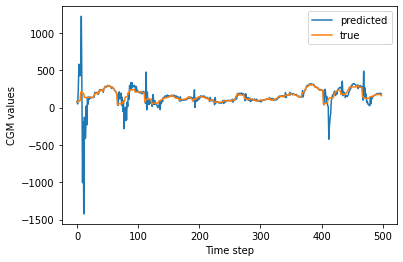

In [95]:
plt.plot(compare[:, 0], label='predicted')
plt.plot(compare[:, 1], label='true')
plt.ylabel('CGM values')
plt.xlabel('Time step')
plt.legend()
plt.show()

#### Analyze $R_{a}$ values, we see that it does not show any specific pattern for meal vs non-meal

Text(0, 0.5, 'R_a values')

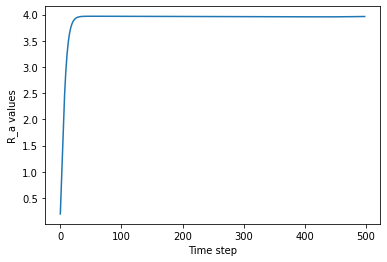

In [96]:
plt.plot(R_a)
plt.xlabel('Time step')
plt.ylabel('R_a values')

#### So we again use thresholding technique on the resdiual = $|CGM_{predicted} - CGM_{actual}|$ to detect meal or no-meal

### Again as before, we learn a threshold value empirically, and evaluate our technique by taking random K folds of the data

In [97]:
cgm_to_meal = data
meal_start_indices = cgm_to_meal.loc[cgm_to_meal['meal_start']==1].index.tolist()
meal_30_indices = cgm_to_meal.loc[cgm_to_meal['meal']==1].index.tolist()
meal_indices = np.concatenate((meal_start_indices,meal_30_indices),axis=0).tolist()
non_meal_indices = cgm_to_meal.loc[(cgm_to_meal['meal']==0) & (cgm_to_meal['meal_start']==0) ].index.tolist()

#### Equivalent to taking K-folds

In [98]:
NUM_POINTS_MEAL = 800
NUM_POINTS_NON_MEAL = 1500
NUM_TRAIN_POINTS = 500

meal_indices_random = random.sample(meal_indices, NUM_POINTS_MEAL)
non_meal_indices_random = random.sample(non_meal_indices, NUM_POINTS_NON_MEAL)
D = [(meal_indices_random,'1'),(non_meal_indices_random,'0')]

In [99]:
meal_diff = []
non_meal_diff = []

for d in D:
    for count, idx in enumerate(d[0]):
        if d[1] == '1':
            print("Random meal point no: ", count + 1, " / ", NUM_POINTS_MEAL)
        else:
            print("Random non meal point no: ", count + 1, " / ", NUM_POINTS_NON_MEAL)
            
        if(idx >= NUM_TRAIN_POINTS):
            startIndex = idx - NUM_TRAIN_POINTS
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points].values
        else:
            startIndex = 0
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points].values

        dt = 5 # time between samples
        points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
        kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)


        # remaining inputs are taken directly from the paper
        kf.x = np.array([0, train[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
        kf.R = np.array([100])
        kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

        compare = []
        k = 1
        G_s_history = [0 for _ in range(len(train))]
        G_s_history[0] = train[0]
        prediction_found_flag = True
        for y in train[1:]:
            try:
                kf.predict()
                compare.append((kf.x[1], y))
                kf.update(y)
                k += 1
            except Exception:
                prediction_found_flag = False
        compare = np.array(compare)
       
        try:
            kf.predict()
            meal_prediction = kf.x[1]
        except Exception:
            prediction_found_flag = False
    
        if prediction_found_flag:
            if(d[1] == '1'):
                meal_diff.append(abs(meal_prediction - cgm_to_meal['cgm'].loc[idx]))
            else:
                non_meal_diff.append(abs(meal_prediction - cgm_to_meal['cgm'].loc[idx]))
        else:
            print("Prediction not found")

meal_diff = np.array(meal_diff)
non_meal_diff = np.array(non_meal_diff)

Random meal point no:  1  /  800
Random meal point no:  2  /  800
Random meal point no:  3  /  800
Random meal point no:  4  /  800
Random meal point no:  5  /  800
Random meal point no:  6  /  800
Random meal point no:  7  /  800
Random meal point no:  8  /  800
Random meal point no:  9  /  800
Random meal point no:  10  /  800
Random meal point no:  11  /  800
Random meal point no:  12  /  800
Random meal point no:  13  /  800
Random meal point no:  14  /  800
Random meal point no:  15  /  800
Random meal point no:  16  /  800
Random meal point no:  17  /  800
Random meal point no:  18  /  800
Random meal point no:  19  /  800
Random meal point no:  20  /  800
Random meal point no:  21  /  800
Random meal point no:  22  /  800
Random meal point no:  23  /  800
Random meal point no:  24  /  800
Random meal point no:  25  /  800
Random meal point no:  26  /  800
Random meal point no:  27  /  800
Random meal point no:  28  /  800
Random meal point no:  29  /  800
Random meal point no:  

Random meal point no:  240  /  800
Random meal point no:  241  /  800
Random meal point no:  242  /  800
Random meal point no:  243  /  800
Random meal point no:  244  /  800
Random meal point no:  245  /  800
Random meal point no:  246  /  800
Random meal point no:  247  /  800
Random meal point no:  248  /  800
Random meal point no:  249  /  800
Random meal point no:  250  /  800
Random meal point no:  251  /  800
Random meal point no:  252  /  800
Random meal point no:  253  /  800
Random meal point no:  254  /  800
Random meal point no:  255  /  800
Random meal point no:  256  /  800
Random meal point no:  257  /  800
Random meal point no:  258  /  800
Random meal point no:  259  /  800
Random meal point no:  260  /  800
Random meal point no:  261  /  800
Random meal point no:  262  /  800
Random meal point no:  263  /  800
Random meal point no:  264  /  800
Random meal point no:  265  /  800
Random meal point no:  266  /  800
Random meal point no:  267  /  800
Random meal point no

Random meal point no:  475  /  800
Random meal point no:  476  /  800
Random meal point no:  477  /  800
Random meal point no:  478  /  800
Random meal point no:  479  /  800
Random meal point no:  480  /  800
Random meal point no:  481  /  800
Random meal point no:  482  /  800
Random meal point no:  483  /  800
Random meal point no:  484  /  800
Random meal point no:  485  /  800
Random meal point no:  486  /  800
Random meal point no:  487  /  800
Random meal point no:  488  /  800
Random meal point no:  489  /  800
Random meal point no:  490  /  800
Random meal point no:  491  /  800
Random meal point no:  492  /  800
Random meal point no:  493  /  800
Random meal point no:  494  /  800
Random meal point no:  495  /  800
Random meal point no:  496  /  800
Random meal point no:  497  /  800
Random meal point no:  498  /  800
Random meal point no:  499  /  800
Random meal point no:  500  /  800
Random meal point no:  501  /  800
Random meal point no:  502  /  800
Random meal point no

Random meal point no:  710  /  800
Random meal point no:  711  /  800
Random meal point no:  712  /  800
Random meal point no:  713  /  800
Random meal point no:  714  /  800
Random meal point no:  715  /  800
Random meal point no:  716  /  800
Random meal point no:  717  /  800
Random meal point no:  718  /  800
Random meal point no:  719  /  800
Random meal point no:  720  /  800
Random meal point no:  721  /  800
Random meal point no:  722  /  800
Random meal point no:  723  /  800
Random meal point no:  724  /  800
Random meal point no:  725  /  800
Random meal point no:  726  /  800
Random meal point no:  727  /  800
Random meal point no:  728  /  800
Random meal point no:  729  /  800
Random meal point no:  730  /  800
Random meal point no:  731  /  800
Random meal point no:  732  /  800
Random meal point no:  733  /  800
Random meal point no:  734  /  800
Random meal point no:  735  /  800
Random meal point no:  736  /  800
Random meal point no:  737  /  800
Random meal point no

Random non meal point no:  129  /  1500
Random non meal point no:  130  /  1500
Random non meal point no:  131  /  1500
Random non meal point no:  132  /  1500
Random non meal point no:  133  /  1500
Random non meal point no:  134  /  1500
Random non meal point no:  135  /  1500
Random non meal point no:  136  /  1500
Random non meal point no:  137  /  1500
Random non meal point no:  138  /  1500
Random non meal point no:  139  /  1500
Random non meal point no:  140  /  1500
Random non meal point no:  141  /  1500
Random non meal point no:  142  /  1500
Random non meal point no:  143  /  1500
Random non meal point no:  144  /  1500
Random non meal point no:  145  /  1500
Random non meal point no:  146  /  1500
Random non meal point no:  147  /  1500
Random non meal point no:  148  /  1500
Random non meal point no:  149  /  1500
Random non meal point no:  150  /  1500
Random non meal point no:  151  /  1500
Random non meal point no:  152  /  1500
Random non meal point no:  153  /  1500


Random non meal point no:  334  /  1500
Random non meal point no:  335  /  1500
Random non meal point no:  336  /  1500
Random non meal point no:  337  /  1500
Random non meal point no:  338  /  1500
Random non meal point no:  339  /  1500
Random non meal point no:  340  /  1500
Random non meal point no:  341  /  1500
Random non meal point no:  342  /  1500
Random non meal point no:  343  /  1500
Random non meal point no:  344  /  1500
Random non meal point no:  345  /  1500
Random non meal point no:  346  /  1500
Random non meal point no:  347  /  1500
Random non meal point no:  348  /  1500
Random non meal point no:  349  /  1500
Random non meal point no:  350  /  1500
Random non meal point no:  351  /  1500
Random non meal point no:  352  /  1500
Random non meal point no:  353  /  1500
Random non meal point no:  354  /  1500
Random non meal point no:  355  /  1500
Random non meal point no:  356  /  1500
Random non meal point no:  357  /  1500
Random non meal point no:  358  /  1500


Random non meal point no:  540  /  1500
Random non meal point no:  541  /  1500
Random non meal point no:  542  /  1500
Random non meal point no:  543  /  1500
Random non meal point no:  544  /  1500
Random non meal point no:  545  /  1500
Random non meal point no:  546  /  1500
Random non meal point no:  547  /  1500
Random non meal point no:  548  /  1500
Random non meal point no:  549  /  1500
Random non meal point no:  550  /  1500
Random non meal point no:  551  /  1500
Random non meal point no:  552  /  1500
Random non meal point no:  553  /  1500
Random non meal point no:  554  /  1500
Random non meal point no:  555  /  1500
Random non meal point no:  556  /  1500
Random non meal point no:  557  /  1500
Random non meal point no:  558  /  1500
Random non meal point no:  559  /  1500
Random non meal point no:  560  /  1500
Random non meal point no:  561  /  1500
Random non meal point no:  562  /  1500
Random non meal point no:  563  /  1500
Random non meal point no:  564  /  1500


Random non meal point no:  746  /  1500
Random non meal point no:  747  /  1500
Random non meal point no:  748  /  1500
Random non meal point no:  749  /  1500
Random non meal point no:  750  /  1500
Random non meal point no:  751  /  1500
Random non meal point no:  752  /  1500
Random non meal point no:  753  /  1500
Random non meal point no:  754  /  1500
Random non meal point no:  755  /  1500
Random non meal point no:  756  /  1500
Random non meal point no:  757  /  1500
Random non meal point no:  758  /  1500
Random non meal point no:  759  /  1500
Random non meal point no:  760  /  1500
Random non meal point no:  761  /  1500
Random non meal point no:  762  /  1500
Random non meal point no:  763  /  1500
Random non meal point no:  764  /  1500
Random non meal point no:  765  /  1500
Random non meal point no:  766  /  1500
Random non meal point no:  767  /  1500
Random non meal point no:  768  /  1500
Random non meal point no:  769  /  1500
Random non meal point no:  770  /  1500


Random non meal point no:  951  /  1500
Random non meal point no:  952  /  1500
Random non meal point no:  953  /  1500
Random non meal point no:  954  /  1500
Random non meal point no:  955  /  1500
Random non meal point no:  956  /  1500
Random non meal point no:  957  /  1500
Random non meal point no:  958  /  1500
Random non meal point no:  959  /  1500
Random non meal point no:  960  /  1500
Random non meal point no:  961  /  1500
Random non meal point no:  962  /  1500
Random non meal point no:  963  /  1500
Random non meal point no:  964  /  1500
Random non meal point no:  965  /  1500
Random non meal point no:  966  /  1500
Random non meal point no:  967  /  1500
Random non meal point no:  968  /  1500
Random non meal point no:  969  /  1500
Random non meal point no:  970  /  1500
Random non meal point no:  971  /  1500
Random non meal point no:  972  /  1500
Random non meal point no:  973  /  1500
Random non meal point no:  974  /  1500
Random non meal point no:  975  /  1500


Random non meal point no:  1153  /  1500
Random non meal point no:  1154  /  1500
Random non meal point no:  1155  /  1500
Random non meal point no:  1156  /  1500
Random non meal point no:  1157  /  1500
Random non meal point no:  1158  /  1500
Random non meal point no:  1159  /  1500
Random non meal point no:  1160  /  1500
Random non meal point no:  1161  /  1500
Random non meal point no:  1162  /  1500
Random non meal point no:  1163  /  1500
Random non meal point no:  1164  /  1500
Random non meal point no:  1165  /  1500
Random non meal point no:  1166  /  1500
Random non meal point no:  1167  /  1500
Random non meal point no:  1168  /  1500
Random non meal point no:  1169  /  1500
Random non meal point no:  1170  /  1500
Random non meal point no:  1171  /  1500
Random non meal point no:  1172  /  1500
Random non meal point no:  1173  /  1500
Random non meal point no:  1174  /  1500
Random non meal point no:  1175  /  1500
Random non meal point no:  1176  /  1500
Random non meal 

Random non meal point no:  1352  /  1500
Random non meal point no:  1353  /  1500
Random non meal point no:  1354  /  1500
Random non meal point no:  1355  /  1500
Random non meal point no:  1356  /  1500
Random non meal point no:  1357  /  1500
Random non meal point no:  1358  /  1500
Random non meal point no:  1359  /  1500
Random non meal point no:  1360  /  1500
Random non meal point no:  1361  /  1500
Random non meal point no:  1362  /  1500
Random non meal point no:  1363  /  1500
Random non meal point no:  1364  /  1500
Random non meal point no:  1365  /  1500
Random non meal point no:  1366  /  1500
Random non meal point no:  1367  /  1500
Random non meal point no:  1368  /  1500
Random non meal point no:  1369  /  1500
Random non meal point no:  1370  /  1500
Random non meal point no:  1371  /  1500
Random non meal point no:  1372  /  1500
Random non meal point no:  1373  /  1500
Random non meal point no:  1374  /  1500
Random non meal point no:  1375  /  1500
Random non meal 

In [100]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
plot_meal_diff = reject_outliers(meal_diff, 5)
plot_non_meal_diff = reject_outliers(non_meal_diff, 5)

Text(0, 0.5, 'residual value')

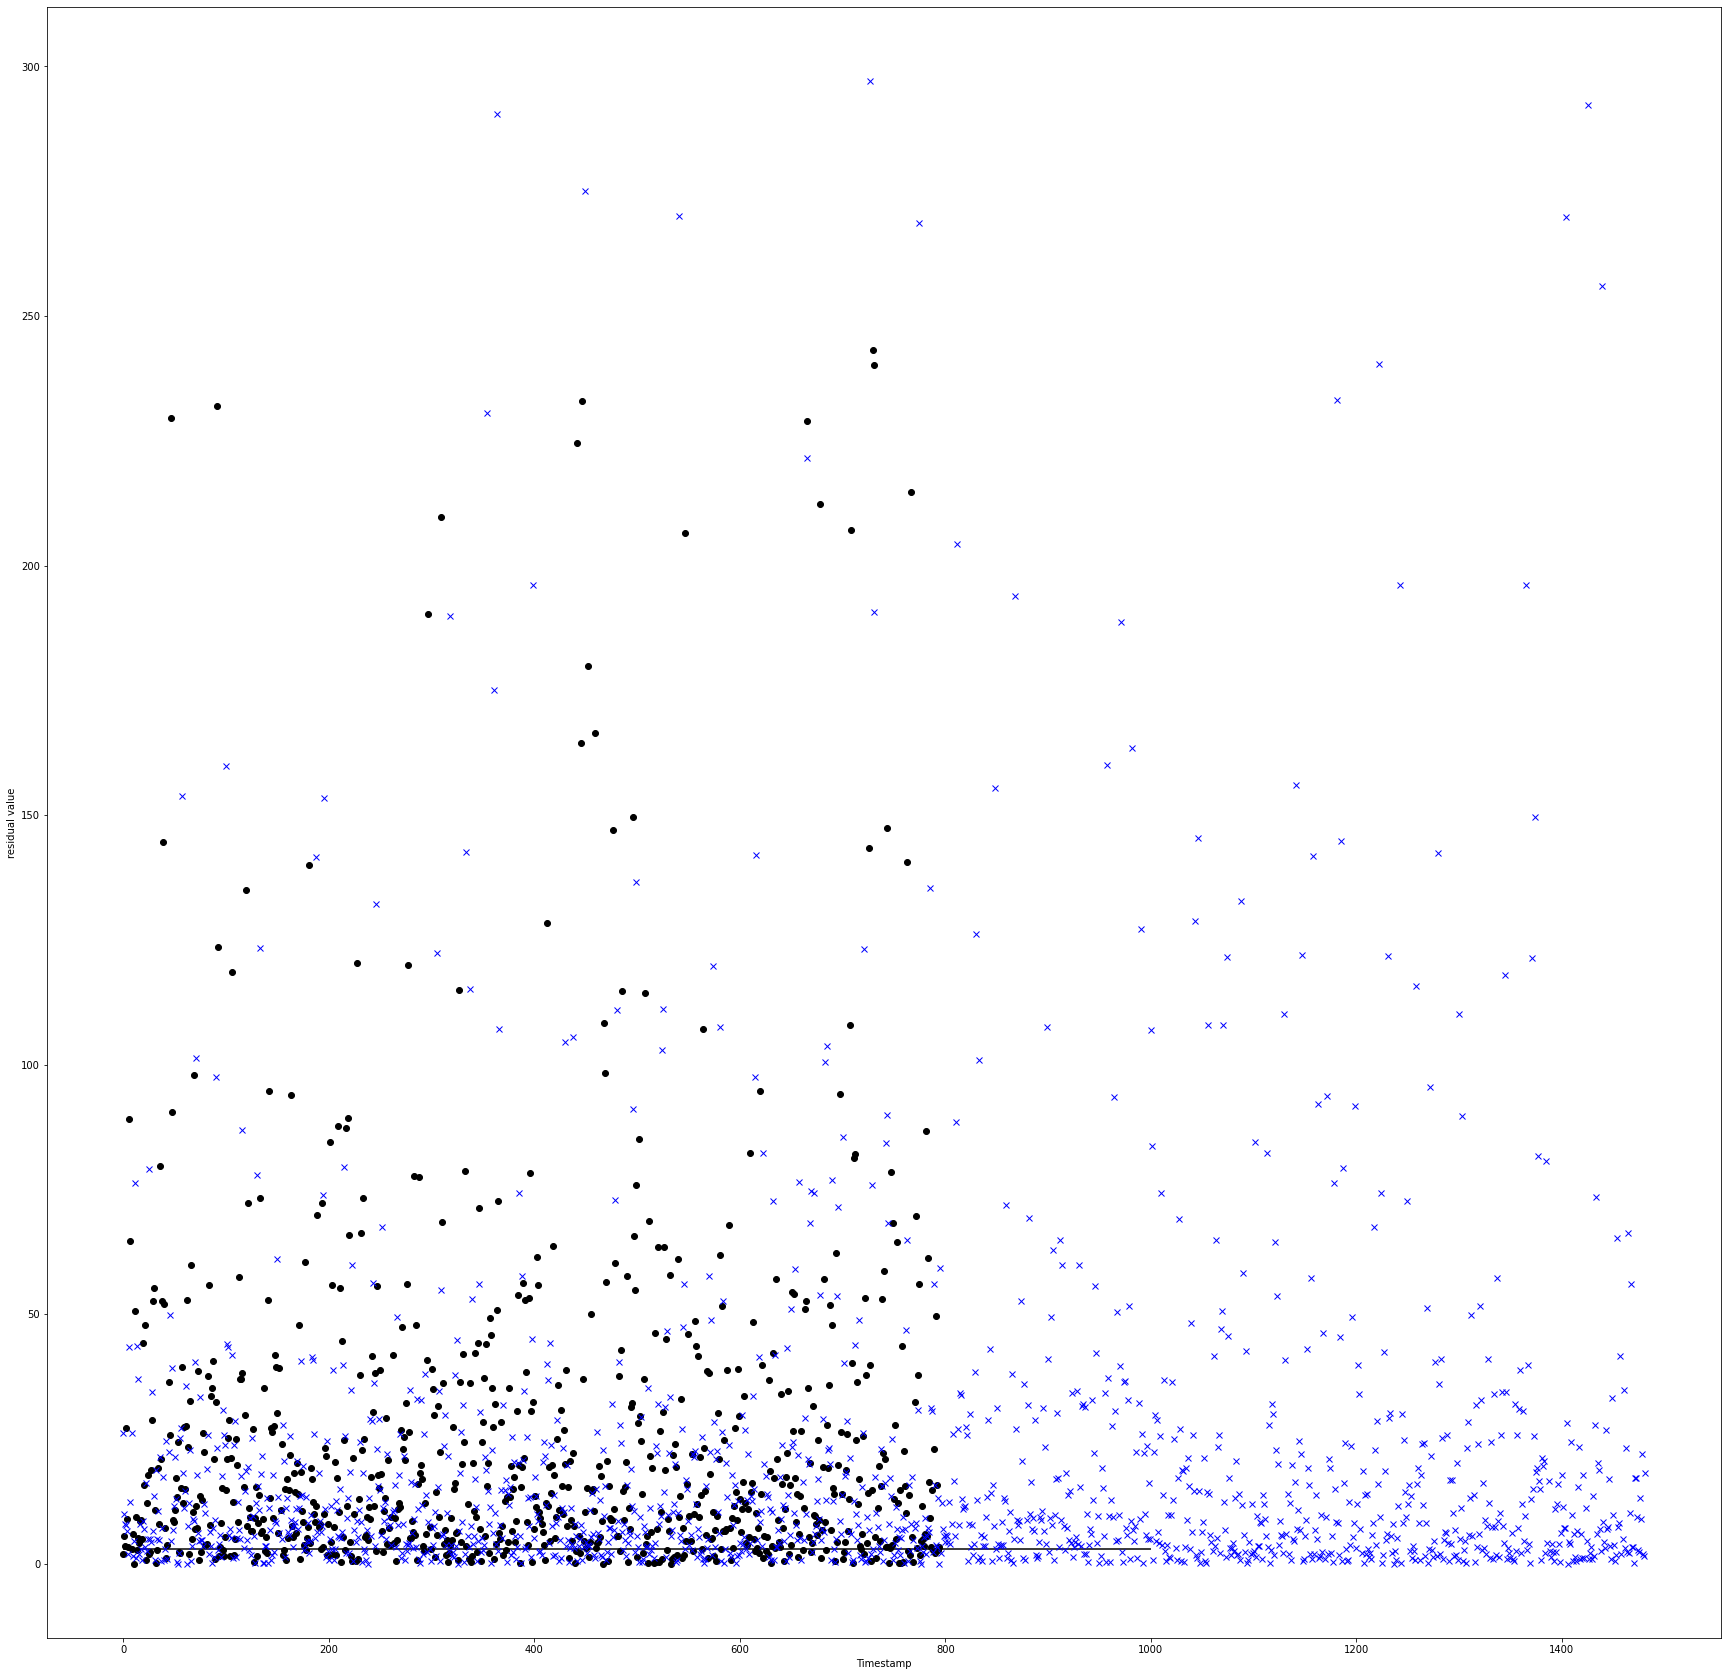

In [101]:
plt.figure(figsize=(30, 30))
plt.plot(plot_meal_diff, 'o', color='black')
plt.plot(plot_non_meal_diff, 'x', color='blue')
plt.hlines(3.0, 0, 1000, color='black')
plt.xlabel('Timestamp')
plt.ylabel('residual value')

### Final metric evaluation for the approach
#### Threshold = $|CGM_{predicted} - CGM_{actual}|$

In [107]:
threshold = 20

non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

print("TNR (non-meal -> non-meal)", true_negative)
print("TPR (meal -> meal)", true_positive)
print("FPR (non-meal -> meal)", false_positive)
print("FNR (meal -> non-meal)", true_negative)
detected_correctly = non_meal_diff[non_meal_diff < threshold].__len__() + meal_diff[meal_diff >= threshold].__len__()
total_points = meal_diff.__len__() + non_meal_diff.__len__()
accuracy = (detected_correctly) / (total_points)
print("Accuracy: ", accuracy )

TNR (non-meal -> non-meal) 0.7052139037433155
TPR (meal -> meal) 0.3825
FPR (non-meal -> meal) 0.2947860962566845
FNR (meal -> non-meal) 0.7052139037433155
Accuracy:  0.5927700348432056
